In [286]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader

class FixedLinearRegression(nn.Module):
    '''
    linear layer for computing sum of dot product
    '''
    def __init__(self, d_model):
        super(FixedLinearRegression, self).__init__()
        self.weight = nn.Parameter(
            torch.ones(1, d_model)
        )  # Fixed weight initialized to 1
        self.bias = nn.Parameter(torch.zeros(1))  # Bias initialized to 0
        
        # Freeze the parameters
        self.weight.requires_grad = False
        self.bias.requires_grad = False

    def forward(self, x):
        return torch.matmul(x, self.weight.t()) + self.bias
        
def cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two arrays of shape (number_samples, dim).
    
    Parameters:
        vec1 (np.ndarray): First array of shape (number_samples, dim).
        vec2 (np.ndarray): Second array of shape (number_samples, dim).
    
    Returns:
        np.ndarray: Cosine similarity between the two arrays of shape (number_samples,).
    """
    dot_product = np.sum(vec1 * vec2, axis=1)
    norm1 = np.linalg.norm(vec1, axis=1)
    norm2 = np.linalg.norm(vec2, axis=1)
    cosine_sim = dot_product / (norm1 * norm2)
    return cosine_sim


# Define the SiameseRegressionModel class
class SiameseRegressionModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            #nn.ReLU()
        )
        self.train_loss =[]
        self.val_loss =[]
        self.fc = nn.Linear(hidden_size, output_size)
        self.fixed_linear_regression = FixedLinearRegression(hidden_size)
        self.cosine_similarity = nn.CosineSimilarity(dim=1)
    def forward(self, input1, input2):
        emb0 = self.shared_layers(input1)
        emb1 = self.shared_layers(input2)


        # using my custom function
        #emb0_l2 = torch.norm(emb0, p=2, dim=-1, keepdim=True)
        #emb1_l2 = torch.norm(emb1, p=2, dim=-1, keepdim=True)
        #emb = (emb0 * emb1) / (emb0_l2 * emb1_l2)
        #prediction = self.fixed_linear_regression(emb)

        # using library
        prediction=self.cosine_similarity(emb0,emb1)
        return prediction

    def training_step(self, batch, batch_idx):
        input1, input2, y = batch
        output = self(input1, input2)
        loss = F.mse_loss(output, y)
        self.train_loss.append(loss.item())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input1, input2, y = batch
        output = self(input1, input2)
        val_loss = F.mse_loss(output, y)
        self.val_loss.append(val_loss.item())
        self.log('val_loss', val_loss, prog_bar=True)
        return val_loss

    def predict_step(self, batch, batch_idx):
        """A predict step"""
        spec = self(batch)
        return spec
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

# Generate synthetic data for training and validation
def generate_data(num_samples, input_size):
    X1 = np.random.randn(num_samples, input_size) 
    X2 = np.random.randn(num_samples, input_size) 

    noise_x1= 0.3*np.random.randn(num_samples, input_size) 
    noise_x2= 0.3*np.random.randn(num_samples, input_size) 
    
    #y=abs(1-   abs((np.sum(X1, axis=1)/np.sum(X2, axis=1))   ))
    #y =  cosine_similarity(X1, X2)# Regression target
    #y =  cosine_similarity(X1, X2[:,::-1])# Regression target
    maximums_X1 = np.max(X1, axis=1)+np.min(X1, axis=1)
    maximums_X2 = np.max(X2, axis=1) + np.min(X1, axis=1)

    maximum_value = np.max(np.stack([maximums_X1, maximums_X2], axis=1), axis=1)
    minimum_value = np.max(np.stack([maximums_X1, maximums_X2], axis=1), axis=1)

    y = minimum_value/maximum_value

    return_X1= torch.tensor(X1+ noise_x1, dtype=torch.float32) 
    return_X2= torch.tensor(X2+ noise_x2, dtype=torch.float32)  
    return return_X1, return_X2 , torch.tensor(y, dtype=torch.float32)

# Create model, loss function, and optimizer
input_size = 3  # Size of input vectors
hidden_size = 64  # Size of hidden layers
output_size = 1  # Regression output size
learning_rate = 0.00001
num_epochs = 1000
batch_size = 32
num_samples = 1000  # Number of training samples
early_stopping_patience = 20  # Number of epochs to wait for improvement

# Generate synthetic training and validation data
X1_train, X2_train, y_train = generate_data(num_samples, input_size)
X1_val, X2_val, y_val = generate_data(num_samples // 10, input_size)

# Initialize Lightning model
model = SiameseRegressionModel(input_size, hidden_size, output_size)
model.learning_rate = learning_rate

# Initialize EarlyStopping callback to monitor training loss
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='train_loss',
    patience=early_stopping_patience,
    mode='min'
)

# Initialize Trainer
trainer = pl.Trainer(callbacks=[early_stopping_callback], max_epochs=100)

# Start training
train_dataloader = DataLoader(TensorDataset(X1_train, X2_train, y_train), batch_size=batch_size)
val_dataloader = DataLoader(TensorDataset(X1_val, X2_val, y_val), batch_size=batch_size)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type                  | Params
------------------------------------------------------------------
0 | shared_layers           | Sequential            | 4.4 K 
1 | fc                      | Linear                | 65    
2 | fixed_linear_regression | FixedLinearRegression | 65    
3 | cosine_similarity       | CosineSimilarity      | 0     
------------------------------------------------------------------
4.5 K     Trainable params
65        Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


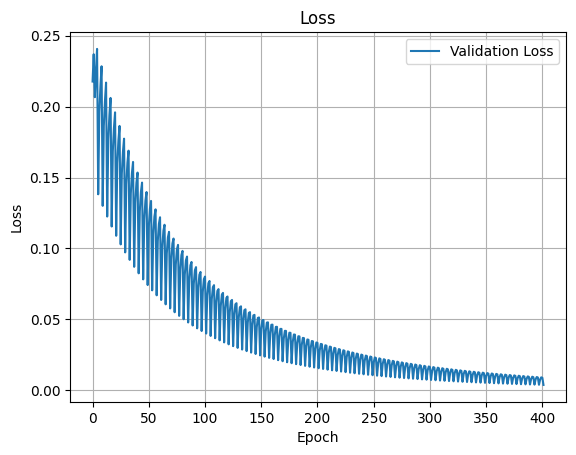

In [288]:
import matplotlib.pyplot as plt
# Plot the validation loss function
#plt.plot(range(len(model.train_loss)), model.train_loss, label='Train Loss')
plt.plot(range(len(model.val_loss)), model.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

In [289]:
X1_test, X2_test, y_test = generate_data(num_samples // 10, input_size)

In [290]:
#cosine_similarity(np.array(X1_test), np.array(X2_test)[:,::-1])

In [291]:
model.forward(X1_test, X2_test)[0:10]

tensor([0.9484, 0.9172, 0.9735, 0.8853, 0.8840, 0.9454, 0.9403, 0.9392, 0.8748,
        0.8987], grad_fn=<SliceBackward0>)

In [292]:
def custom_cos_sim(emb0, emb1):
                emb0_l2 = torch.norm(emb0, p=2, dim=-1, keepdim=True)
                emb1_l2 = torch.norm(emb1, p=2, dim=-1, keepdim=True)
                emb = (emb0 * emb1) / (emb0_l2 * emb1_l2)
                emb = FixedLinearRegression(emb.shape[1])(emb)
                return emb

In [293]:
custom_cos_sim(X1_test, X2_test)

tensor([[-0.7046],
        [-0.9991],
        [ 0.6689],
        [-0.8573],
        [-0.3788],
        [ 0.3539],
        [ 0.2702],
        [ 0.0744],
        [-0.0112],
        [-0.8596],
        [ 0.4400],
        [ 0.2126],
        [-0.2503],
        [ 0.6343],
        [-0.2348],
        [ 0.2919],
        [ 0.2391],
        [ 0.0199],
        [ 0.5099],
        [-0.5191],
        [-0.1455],
        [ 0.3575],
        [ 0.8723],
        [ 0.6373],
        [ 0.6213],
        [-0.2871],
        [ 0.9608],
        [-0.6726],
        [-0.3960],
        [ 0.7666],
        [-0.2371],
        [ 0.2203],
        [ 0.7936],
        [-0.8459],
        [ 0.8119],
        [-0.6298],
        [-0.8896],
        [-0.5461],
        [-0.0385],
        [ 0.7548],
        [-0.5988],
        [-0.0685],
        [-0.6254],
        [-0.3425],
        [-0.6897],
        [-0.0793],
        [-0.1512],
        [ 0.3294],
        [-0.7966],
        [ 0.0584],
        [ 0.8822],
        [-0.2596],
        [-0.

In [294]:
nn.CosineSimilarity(dim=1)(X1_test, X2_test)

tensor([-0.7046, -0.9991,  0.6689, -0.8573, -0.3788,  0.3539,  0.2702,  0.0744,
        -0.0112, -0.8596,  0.4400,  0.2126, -0.2503,  0.6343, -0.2348,  0.2919,
         0.2391,  0.0199,  0.5099, -0.5191, -0.1455,  0.3575,  0.8723,  0.6373,
         0.6213, -0.2871,  0.9608, -0.6726, -0.3960,  0.7666, -0.2371,  0.2203,
         0.7936, -0.8459,  0.8119, -0.6298, -0.8896, -0.5461, -0.0385,  0.7548,
        -0.5988, -0.0685, -0.6254, -0.3425, -0.6897, -0.0793, -0.1512,  0.3294,
        -0.7966,  0.0584,  0.8822, -0.2596, -0.2337,  0.2274,  0.7122, -0.8618,
        -0.9838,  0.2779, -0.0230,  0.8151, -0.5827,  0.8451, -0.3960,  0.7904,
         0.2550,  0.0573,  0.9279,  0.7746, -0.9419,  0.3392,  0.9692,  0.0030,
         0.1389, -0.6653, -0.7014, -0.2330, -0.3642,  0.3573,  0.9539, -0.6084,
        -0.9969,  0.2944,  0.2866,  0.4946,  0.3700, -0.2109,  0.6305, -0.3799,
         0.5977, -0.3773,  0.0749, -0.1705,  0.7999,  0.4952, -0.3561,  0.1172,
         0.5584, -0.7710,  0.0409,  0.86

In [297]:
# Example tensors
tensor1 = torch.tensor([1.0, 2.0])
tensor2 = torch.tensor([[1.0], [2.0]])

# Define the MSE loss function
mse_loss = nn.MSELoss()

# Compute the loss
loss = mse_loss(tensor1, tensor2)

print("MSE Loss:", loss.item())

MSE Loss: 0.5


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
result.float()

In [ ]:
import math
((1**2)+(6**2)+(0**2)+(5**2))/4